# Phase 1 — SQL EDA (Hospital Readmission)

This notebook performs **exploratory data analysis (EDA)** and **SQL-based analysis** on the
UCI dataset *"Diabetes 130-US hospitals for years 1999–2008"*.

## Prerequisites
1. Create the DuckDB database by running (from the project root):
```bash
python src/data_ingest.py --download
```

2. Ensure the database exists at:
- `data/processed/readmission.duckdb`

Notes:
- Do **not** commit `data/` or `mlruns/` to git (they should be ignored).
- This dataset contains sensitive demographic attributes (race/age/gender). Use responsibly.


In [1]:
from __future__ import annotations

from pathlib import Path
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

def find_project_root(start: Path | None = None) -> Path:
    """Walk upwards to find the project root (folder containing 'data' and 'src')."""
    start = start or Path.cwd()
    cur = start.resolve()
    for _ in range(10):
        if (cur / "data").exists() and (cur / "src").exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    raise RuntimeError("Could not locate project root. Run the notebook from inside the project folder.")

ROOT = find_project_root()
DB_PATH = ROOT / "data" / "processed" / "readmission.duckdb"

print("Project root:", ROOT)
print("DB path:", DB_PATH)

if not DB_PATH.exists():
    raise FileNotFoundError(
        f"DuckDB database not found at {DB_PATH}.\n"
        "Run: python src/data_ingest.py --download"
    )

con = duckdb.connect(str(DB_PATH))


Project root: C:\Users\amirm\Programming\Data Science Portfolio\projects\health-readmission-risk
DB path: C:\Users\amirm\Programming\Data Science Portfolio\projects\health-readmission-risk\data\processed\readmission.duckdb


## 1) Basic sanity checks

In [2]:
df_counts = con.execute('''
SELECT
  COUNT(*) AS n_encounters,
  COUNT(DISTINCT patient_nbr) AS n_patients,
  SUM(readmission_30d) AS n_readmit_30d
FROM encounters
''').df()

df_counts


,n_encounters,n_patients,n_readmit_30d
0,101766,71518,11357.0


In [3]:
df_readmitted = con.execute('''
SELECT readmitted, COUNT(*) AS n
FROM encounters
GROUP BY readmitted
ORDER BY n DESC
''').df()

df_readmitted


,readmitted,n
0,NO,54864
1,>30,35545
2,<30,11357


Readmission <30d rate: 0.1116 (11.16%)


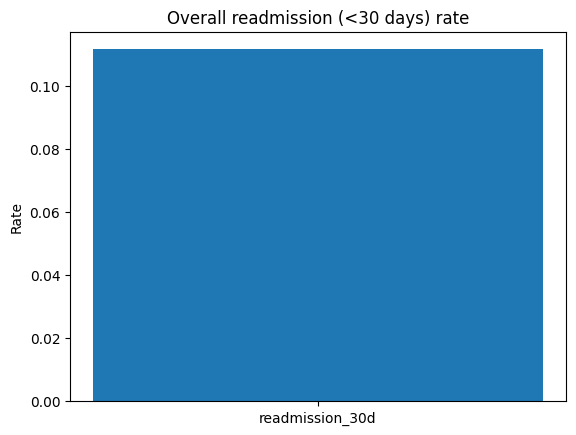

In [4]:
rate_30d = con.execute('SELECT AVG(readmission_30d) AS rate FROM encounters').fetchone()[0]
print(f"Readmission <30d rate: {rate_30d:.4f} ({rate_30d*100:.2f}%)")

plt.figure()
plt.bar(["readmission_30d"], [rate_30d])
plt.ylabel("Rate")
plt.title("Overall readmission (<30 days) rate")
plt.show()


## 2) Missingness overview (selected columns)

In [5]:
# In this dataset, missing values were standardized to NULL in the ingest script.
# We'll compute missingness for a selected set of high-signal columns.

cols = [
    "race", "gender", "age",
    "medical_specialty", "payer_code",
    "diag_1", "diag_2", "diag_3",
    "max_glu_serum", "A1Cresult"
]

# Keep only columns that exist in the table (defensive)
existing_cols = set(con.execute("DESCRIBE encounters").df()["column_name"].tolist())
cols = [c for c in cols if c in existing_cols]

n_total = con.execute("SELECT COUNT(*) FROM encounters").fetchone()[0]

rows = []
for c in cols:
    missing = con.execute(f"SELECT SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) FROM encounters").fetchone()[0]
    rows.append({"column": c, "missing": int(missing), "missing_pct": float(missing) / n_total})

df_missing = pd.DataFrame(rows).sort_values("missing_pct", ascending=False)
df_missing


,column,missing,missing_pct
8,max_glu_serum,96420,0.947468
9,A1Cresult,84748,0.832773
3,medical_specialty,49949,0.490822
4,payer_code,40256,0.395574
0,race,2273,0.022336
7,diag_3,1423,0.013983
6,diag_2,358,0.003518
5,diag_1,21,0.000206
1,gender,0,0.000000
2,age,0,0.000000


## 3) SQL analysis (queries)

In [6]:
def q(sql: str) -> pd.DataFrame:
    """Run a SQL query and return a pandas DataFrame."""
    return con.execute(sql).df()


### Q1 — Readmission rate by age group (CTE)

In [7]:
q('''
WITH agg AS (
  SELECT
    age,
    COUNT(*) AS n,
    AVG(readmission_30d) AS readmit_rate_30d
  FROM encounters
  GROUP BY age
)
SELECT *
FROM agg
ORDER BY age
''')


,age,n,readmit_rate_30d
0,[0-10),161,0.018634
1,[10-20),691,0.057887
2,[20-30),1657,0.142426
3,[30-40),3775,0.112318
4,[40-50),9685,0.106040
5,[50-60),17256,0.096662
6,[60-70),22483,0.111284
7,[70-80),26068,0.117731
8,[80-90),17197,0.120835
9,[90-100),2793,0.110992


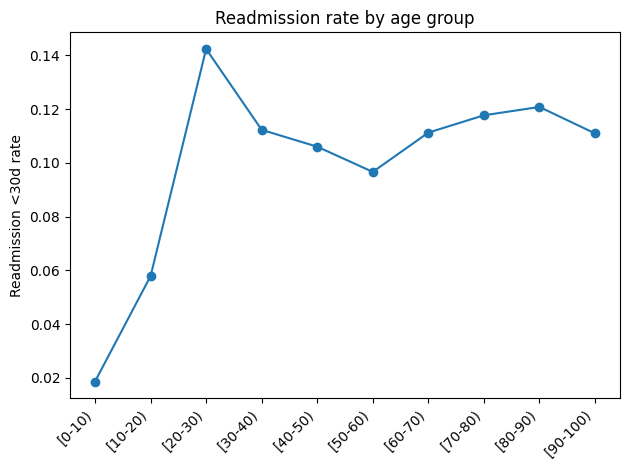

In [8]:
df_age = q('''
SELECT age, AVG(readmission_30d) AS rate
FROM encounters
GROUP BY age
ORDER BY age
''')

plt.figure()
plt.plot(df_age["age"], df_age["rate"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Readmission <30d rate")
plt.title("Readmission rate by age group")
plt.tight_layout()
plt.show()


### Q2 — Readmission rate by gender

In [9]:
q('''
SELECT
  gender,
  COUNT(*) AS n,
  AVG(readmission_30d) AS readmit_rate_30d
FROM encounters
GROUP BY gender
ORDER BY n DESC
''')


,gender,n,readmit_rate_30d
0,Female,54708,0.112452
1,Male,47055,0.110615
2,Unknown/Invalid,3,0.000000


### Q3 — Readmission rate by race

In [10]:
q('''
SELECT
  race,
  COUNT(*) AS n,
  AVG(readmission_30d) AS readmit_rate_30d
FROM encounters
GROUP BY race
ORDER BY readmit_rate_30d DESC
''')


,race,n,readmit_rate_30d
0,Caucasian,76099,0.112906
1,AfricanAmerican,19210,0.112181
2,Hispanic,2037,0.104075
3,Asian,641,0.101404
4,Other,1506,0.096282
5,None,2273,0.082710


### Q4 — Readmission rate by number of medications (binned via CASE + CTE)

In [11]:
q('''
WITH binned AS (
  SELECT
    CASE
      WHEN num_medications < 10 THEN '0-9'
      WHEN num_medications < 20 THEN '10-19'
      WHEN num_medications < 30 THEN '20-29'
      WHEN num_medications < 40 THEN '30-39'
      ELSE '40+'
    END AS meds_bin,
    readmission_30d
  FROM encounters
)
SELECT
  meds_bin,
  COUNT(*) AS n,
  AVG(readmission_30d) AS readmit_rate_30d
FROM binned
GROUP BY meds_bin
ORDER BY meds_bin
''')


,meds_bin,n,readmit_rate_30d
0,0-9,20515,0.088277
1,10-19,53680,0.111978
2,20-29,21485,0.129625
3,30-39,4546,0.125825
4,40+,1540,0.115584


### Q5 — Readmission rate by number of procedures

In [12]:
q('''
SELECT
  num_procedures,
  COUNT(*) AS n,
  AVG(readmission_30d) AS readmit_rate_30d
FROM encounters
GROUP BY num_procedures
ORDER BY num_procedures
''')


,num_procedures,n,readmit_rate_30d
0,0,46652,0.110778
1,1,20742,0.122071
2,2,12717,0.111819
3,3,9443,0.106852
4,4,4180,0.110287
5,5,3078,0.094217
6,6,4954,0.095882


### Q6 — Top primary diagnoses among <30d readmissions (JOIN)

In [13]:
q('''
SELECT
  d.diag_code,
  COUNT(*) AS n_readmit_30d
FROM encounters e
JOIN diagnoses_long d
  ON e.encounter_id = d.encounter_id
WHERE e.readmission_30d = 1
  AND d.diag_position = 1
GROUP BY d.diag_code
ORDER BY n_readmit_30d DESC
LIMIT 15
''')


,diag_code,n_readmit_30d
0,428,968
1,414,595
2,410,373
3,434,329
4,486,314
5,786,291
6,491,287
7,996,264
8,276,257
9,427,252


### Q7 — Diagnosis-level readmission rate with ranking (WINDOW function)

In [14]:
q('''
WITH diag_stats AS (
  SELECT
    d.diag_code,
    COUNT(*) AS n,
    AVG(e.readmission_30d) AS readmit_rate_30d
  FROM encounters e
  JOIN diagnoses_long d
    ON e.encounter_id = d.encounter_id
  WHERE d.diag_position = 1
  GROUP BY d.diag_code
  HAVING COUNT(*) >= 200
)
SELECT
  diag_code,
  n,
  readmit_rate_30d,
  ROW_NUMBER() OVER (ORDER BY readmit_rate_30d DESC) AS rank_by_rate
FROM diag_stats
ORDER BY readmit_rate_30d DESC
LIMIT 20
''')


,diag_code,n,readmit_rate_30d,rank_by_rate
0,V58,228,0.416667,1
1,572,239,0.205021,2
2,250.7,871,0.189437,3
3,250.6,1183,0.185123,4
4,787,267,0.183521,5
5,707,257,0.167315,6
6,571,277,0.162455,7
7,434,2028,0.162229,8
8,440,840,0.158333,9
9,820,1082,0.158041,10


### Q8 — Readmission rate by length of stay (time_in_hospital)

In [15]:
q('''
SELECT
  time_in_hospital,
  COUNT(*) AS n,
  AVG(readmission_30d) AS readmit_rate_30d
FROM encounters
GROUP BY time_in_hospital
ORDER BY time_in_hospital
''')


,time_in_hospital,n,readmit_rate_30d
0,1,14208,0.081785
1,2,17224,0.099396
2,3,17756,0.106668
3,4,13924,0.118070
4,5,9966,0.120309
5,6,7539,0.125879
6,7,5859,0.128350
7,8,4391,0.142337
8,9,3002,0.137242
9,10,2342,0.143467


### Q9 — Patients with frequent encounters and their readmission risk (CTE)

In [16]:
q('''
WITH patient_counts AS (
  SELECT
    patient_nbr,
    COUNT(*) AS n_encounters,
    AVG(readmission_30d) AS readmit_rate_30d
  FROM encounters
  GROUP BY patient_nbr
)
SELECT *
FROM patient_counts
WHERE n_encounters >= 3
ORDER BY n_encounters DESC, readmit_rate_30d DESC
LIMIT 20
''')


,patient_nbr,n_encounters,readmit_rate_30d
0,88785891,40,0.575000
1,43140906,28,0.785714
2,88227540,23,0.521739
3,1660293,23,0.478261
4,23199021,23,0.304348
5,23643405,22,0.545455
6,84428613,22,0.545455
7,92709351,21,0.571429
8,23398488,20,0.600000
9,89472402,20,0.550000


### Q10 — Within each age group: top diagnoses by readmission rate (JOIN + WINDOW)

In [17]:
q('''
WITH diag_by_age AS (
  SELECT
    e.age,
    d.diag_code,
    COUNT(*) AS n,
    AVG(e.readmission_30d) AS readmit_rate_30d
  FROM encounters e
  JOIN diagnoses_long d
    ON e.encounter_id = d.encounter_id
  WHERE d.diag_position = 1
  GROUP BY e.age, d.diag_code
  HAVING COUNT(*) >= 150
),
ranked AS (
  SELECT
    *,
    DENSE_RANK() OVER (PARTITION BY age ORDER BY readmit_rate_30d DESC) AS rnk
  FROM diag_by_age
)
SELECT age, diag_code, n, readmit_rate_30d, rnk
FROM ranked
WHERE rnk <= 3
ORDER BY age, rnk
''')


,age,diag_code,n,readmit_rate_30d,rnk
0,[10-20),250.13,199,0.060302,1
1,[20-30),250.13,215,0.241860,1
2,[20-30),250.11,191,0.214660,2
3,[30-40),250.13,152,0.144737,1
4,[30-40),786,168,0.065476,2
5,[40-50),250.6,250,0.268000,1
6,[40-50),577,292,0.157534,2
7,[40-50),428,297,0.134680,3
8,[50-60),250.7,170,0.205882,1
9,[50-60),434,319,0.153605,2


## Close the connection

In [18]:
con.close()